In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.set_option("display.precision", 2)

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 12, 8

In [140]:
class Model:
    def __init__(self,input_address,alpha=2,beta=5,sigma=3,ro=0.8,theta=80,n_population=100,max_iter=1000):
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.ro = ro
        self.theta = theta
        self.n_population = n_population
        self.max_iter = max_iter

        self.m, self.capacity, self.graph = self.preprocess(input_address)

        self.customers, self.demands = self.graph[1:,0]-1, self.graph[:,3]
        self.depot = self.graph[0,1:3]
        self.dists = np.linalg.norm(self.graph[:,np.newaxis,1:3]-self.graph[np.newaxis,:,1:3], axis=-1)
        self.pheromones = 1/(self.dists+np.diag(np.full(self.dists.shape[0],1)))
    
    def plot(self,solution):
        graph = self.graph

        for (path,color) in zip(solution[0],['b','g','r','c','m','y']):
            src = 0
            for des in path:
                plt.plot([graph[src,1],graph[des,1]],[graph[src,2],graph[des,2]],color)
                src = des
            plt.plot([graph[src,1],graph[0,1]],[graph[src,2],graph[0,2]],color)

        plt.plot(graph[0,1],graph[0,2], 'o')
        plt.plot(graph[1:,1],graph[1:,2], 'o')
        plt.grid(False)
        plt.show()
        
    @staticmethod
    def preprocess(input_address):
        graph = []
        with open(input_address, 'r') as f:
            for i, row in enumerate(f.readlines()):
                if i == 0:
                    temp = [int(x) for x in row.split(' ') if x != '' and x != '\n']
                    m, capacity = temp[0],temp[1]
                else:
                    graph.append([int(x) for x in row.split(' ') if x != '' and x != '\n'])
        return m,capacity,np.array(graph)
    
    def ant_search(self):
        solution = []

        customers = self.customers.tolist()
        demands = self.demands.tolist()

        while(len(customers) != 0):
            path = []
            capacity = self.capacity
            
            customer = np.random.choice(customers)
            capacity -= demands[customer]
            path.append(customer)
            customers.remove(customer)

            while(len(customers) != 0):

                probs = []
                for i in customers:
                    probs.append((self.pheromones[i,customer]**self.alpha)*(1/self.dists[i,customer]**self.beta))
                probs = probs/np.sum(probs)

                customer = np.random.choice(customers, p=probs)
                capacity -= demands[customer]
                
                if capacity > 0:
                    path.append(customer)
                    customers.remove(customer)
                else:
                    break
            solution.append(path)
        return solution

    def evaluate(self,solution):
        dist = 0

        for path in solution:
            src = 0
            for des in path:
                dist += self.dists[src,des]
                src = des
            dist += self.dists[src,0]

        return dist

    def update(self,best_solution,solutions):
        avg_dist = np.sum([x[1] for x in solutions])/len(solutions)
        self.pheromones *= (self.ro+self.theta/avg_dist)
        solutions.sort(key = lambda x: x[1])

        if best_solution:
            if(solutions[0][1] < best_solution[1]):
                best_solution = solutions[0]
            for path in best_solution[0]:
                for i in range(len(path)-1):
                    self.pheromones[path[i],path[i+1]] += self.sigma/best_solution[1]
                    self.pheromones[path[i+1],path[i]] += self.sigma/best_solution[1]

        else:
            best_solution = solutions[0]
        for l in range(self.sigma):
            paths = solutions[l][0]
            dist = solutions[l][1]
            for path in paths:
                for i in range(len(path)-1):
                    self.pheromones[path[i],path[i+1]] += (self.sigma-(l+1)/dist**(l+1))
                    self.pheromones[path[i+1],path[i]] += (self.sigma-(l+1)/dist**(l+1))
        return best_solution
    
    def learn(self):
        best_solution = None

        for _ in range(self.max_iter):
            solutions = []
            for _ in range(self.n_population):
                solution = self.ant_search()
                solutions.append((solution,self.evaluate(solution)))
            best_solution = self.update(best_solution,solutions)
        return best_solution

    

    
            
model = Model('data.txt')
best_solution = model.learn()

Best Solution Distance: 859.48
Best Solution: [[2, 33, 19, 4, 7, 8, 30], [11, 6, 1, 36, 17, 23, 21], [12, 38, 37, 31, 14, 35, 25, 3], [26, 5, 9, 28, 29, 24, 15], [18, 22, 34, 27, 10, 16, 32, 20], [13]]


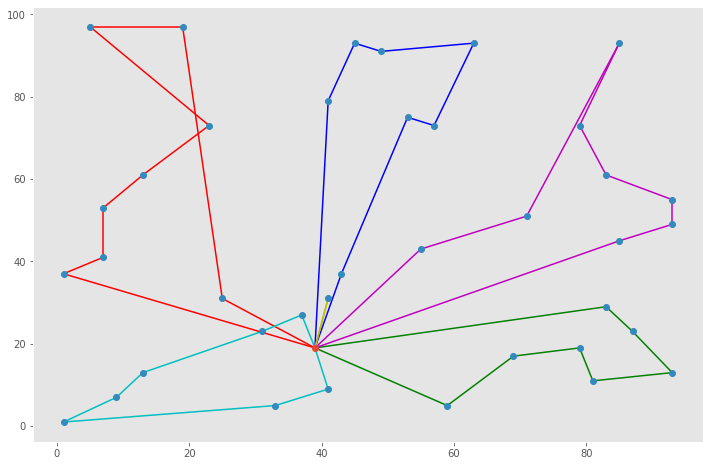

In [148]:
print(f"Best Solution Distance: {best_solution[1]:4.2f}")
print(f"Best Solution: {best_solution[0]}")
model.plot(best_solution)